In [1]:
from tensorflow.python.client import device_lib
import tensorflow as tf
from skill_label_classifier import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from sklearn.metrics import f1_score, accuracy_score

# helper function to find optimal number of PC (elbow method)
def plot_explained_variance(X_train):
    pca = PCA()
    pca_full = pca.fit(X_train)
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel("number of principal components")
    plt.ylabel("cumulative explained variance")
    plt.grid(color='grey',linestyle='-',alpha=0.2)
    plt.show()
    
def preprocess_pca(X_train, X_test, dim, r=None):
    pca = PCA(n_components=dim, random_state=r)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca


experiment = SkillClassifier()
experiment.import_data()
experiment.create_df()

experiment.choose_dataset('vqa')
experiment.set_features(['QSN', 'descriptions', 'tags', 'dominant_colors','handwritten_text', 'ocr_text'])
experiment.set_targets()

features_train = experiment.features_train
features_val   = experiment.features_val


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/edithzeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/edithzeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/edithzeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14657076444922341382
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10221742171494752903
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16477015591085636823
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281927373
locality {
  bus_id: 1
  links {
  }
}
incarnation: 57467016404618834

In [5]:
# check training class distribution
text_recognition_y_train = np.asarray(experiment.txt_train).astype('float32')
color_recognition_y_train = np.asarray(experiment.col_train).astype('float32')
counting_y_train = np.asarray(experiment.cnt_train).astype('float32')

print('Number of training samples each class: ')
print('Text recognition - 1: {} 0: {}'.format(np.count_nonzero(text_recognition_y_train), 
      len(text_recognition_y_train)-np.count_nonzero(text_recognition_y_train)))
print('Color recognition - 1:{} 0: {}'.format(np.count_nonzero(color_recognition_y_train),
      len(color_recognition_y_train)-np.count_nonzero(color_recognition_y_train)))
print('Counting - 1: {} 0: {}'.format(np.count_nonzero(counting_y_train), 
      len(counting_y_train)-np.count_nonzero(counting_y_train)))

n_classes = 3

y_train = np.column_stack((text_recognition_y_train, color_recognition_y_train, counting_y_train))

# check validation class distribution
text_recognition_y_val = np.asarray(experiment.txt_val).astype('float32')
color_recognition_y_val = np.asarray(experiment.col_val).astype('float32')
counting_y_val = np.asarray(experiment.cnt_val).astype('float32')
print('Number of validation samples each class: ')
print('Text recognition - 1: {} 0: {}'.format(np.count_nonzero(text_recognition_y_val), 
      len(text_recognition_y_val)-np.count_nonzero(text_recognition_y_val)))
print('Color recognition - 1:{} 0: {}'.format(np.count_nonzero(color_recognition_y_val),
     len(color_recognition_y_val)-np.count_nonzero(color_recognition_y_val)))
print('Counting - 1:{} 0: {}'.format(np.count_nonzero(counting_y_val),
     len(counting_y_val)-np.count_nonzero(counting_y_val)))

y_val = np.column_stack((text_recognition_y_val, color_recognition_y_val, counting_y_val))

# tokenize
tok         = Tokenizer(num_words=VOCAB_SIZE, 
                       filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                       lower=True,
                       split=" ")
tok.fit_on_texts(features_train)
# create training sequences
train_seq   = tok.texts_to_sequences(features_train)
MAX_DOC_LEN_train = 0
for seq in train_seq:
    MAX_DOC_LEN_train = max(MAX_DOC_LEN_train, len(train_seq))
# create validation sequences
val_seq     = tok.texts_to_sequences(features_val)
MAX_DOC_LEN_val   = 0
for seq in val_seq:
    MAX_DOC_LEN_val = max(MAX_DOC_LEN_val, len(val_seq))
# pad training & validation sequence
MAX_DOC_LEN = min(MAX_DOC_LEN_train, MAX_DOC_LEN_val)
train_seq   = sequence.pad_sequences(train_seq, maxlen=MAX_DOC_LEN)
val_seq     = sequence.pad_sequences(val_seq, maxlen=MAX_DOC_LEN)

# standardize training and testing features
sc = StandardScaler()
train_seq = sc.fit_transform(train_seq)
val_seq = sc.transform(val_seq)

# Set validation data tuple
val_data = (val_seq, y_val)

# punkt sentence level tokenizer
sent_lst = [] 
for doc in features_train:
    sentences = nltk.tokenize.sent_tokenize(doc)
    for sent in sentences:
        word_lst = [w for w in nltk.tokenize.word_tokenize(sent) if w.isalnum()]
        sent_lst.append(word_lst)

EMBEDDING_DIM = 150
googlenews_corpus = '/anaconda/envs/py35/lib/python3.5/site-packages/gensim/test/test_data/GoogleNews-vectors-negative300.bin'
        
# load pre-trained word2vec on GoogleNews (https://code.google.com/archive/p/word2vec/)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(datapath(googlenews_corpus),
                                                                 binary=True)
embeddings_index = {}
for word in word2vec_model.wv.vocab:
    coefs = np.asarray(word2vec_model.wv[word], dtype='float32')
    embeddings_index[word] = coefs
print('Total %s word vectors' % len(embeddings_index))

# Initial word embedding
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tok.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i < VOCAB_SIZE:
        embedding_matrix[i] = embedding_vector

# PCA to reduce dimensionality
N_COMPONENTS = 40
train_seq, val_seq = preprocess_pca(train_seq, val_seq, dim=N_COMPONENTS)

Number of training samples each class: 
Text recognition - 1: 358 0: 2872
Color recognition - 1:1148 0: 2082
Counting - 1: 661 0: 2569
Number of validation samples each class: 
Text recognition - 1: 63 0: 450
Color recognition - 1:179 0: 334
Counting - 1:109 0: 404


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
2019-04-06 18:38:48,485 : INFO : loading projection weights from /anaconda/envs/py35/lib/python3.5/site-packages/gensim/test/test_data/GoogleNews-vectors-negative300.bin
2019-04-06 18:40:20,952 : INFO : loaded (3000000, 300) matrix from /anaconda/envs/py35/lib/python3.5/site-packages/gensim/test/test_data/GoogleNews-vectors-negative300.bi

Total 3000000 word vectors


ValueError: could not broadcast input array from shape (300) into shape (150)

In [13]:
len(word)

6

In [3]:
L = 1e-1
R = 1e-14
B = 64
E = 200
model, history = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=y_train,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R, n_classes=3)
preds = model.predict(val_seq, verbose=0)

Log file: ./LSTM/0.1_0_64_1000.log


In [4]:
y_pred_text = [1 if i >= 0.5 else 0 for i in preds[:,0]]
y_pred_color = [1 if i >= 0.5 else 0 for i in preds[:,1]]
y_pred_counting = [1 if i >= 0.5 else 0 for i in preds[:,2]]
# y_pred = np.column_stack(y_pred_text, y_pred_color, y_pred_counting)
print("VQA, all features - accuracy\ntext: {}\ncolor:{}\ncounting:{}".format(accuracy_score(y_val[:,0], y_pred_text),
                                                        accuracy_score(y_val[:,1], y_pred_color),
                                                        accuracy_score(y_val[:,2], y_pred_counting)))

VQA, all features - accuracy
text: 0.8771929824561403
color:0.6510721247563352
counting:0.7875243664717348


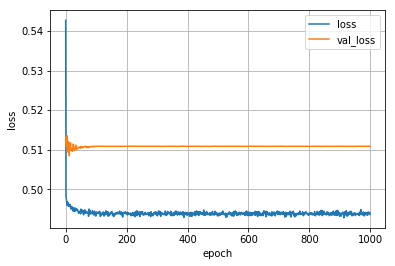

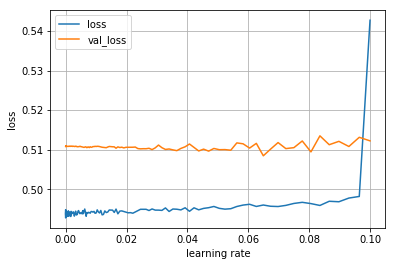

In [5]:
log = pd.read_csv("./LSTM/0.1_0_64_1000.log")
plt.plot(log['epoch'].values, log['loss'].values, label='loss')
plt.plot(log['epoch'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

plt.plot(log['lr'].values, log['loss'].values, label='loss')
plt.plot(log['lr'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.grid()
plt.show()

In [4]:
L = 1e-1
R = 1e-14
B = 64
E = 100
model, history = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=y_train,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R, n_classes=3)

Log file: ./LSTM/0.1_1e-14_64_100.log


In [ ]:
preds = model.predict(val_seq, verbose=0)
y_pred_text = [1 if i >= 0.5 else 0 for i in preds[:,0]]
y_pred_color = [1 if i >= 0.5 else 0 for i in preds[:,1]]
y_pred_counting = [1 if i >= 0.5 else 0 for i in preds[:,2]]
# y_pred = np.column_stack(y_pred_text, y_pred_color, y_pred_counting)
print("VQA, all features - accuracy\ntext: {}\ncolor:{}\ncounting:{}".format(accuracy_score(y_val[:,0], y_pred_text),
                                                        accuracy_score(y_val[:,1], y_pred_color),
                                                        accuracy_score(y_val[:,2], y_pred_counting)))

In [8]:
L = 1
R = 0
B = 64
E = 2000
model, history = lstm_create_train(train_seq, embedding_matrix,
                 train_labels=y_train,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 regularization=R, n_classes=3)
preds = model.predict(val_seq, verbose=0)

Log file: ./LSTM/1_0_64_2000.log


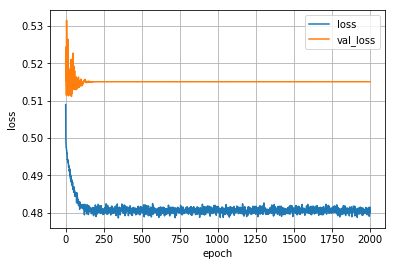

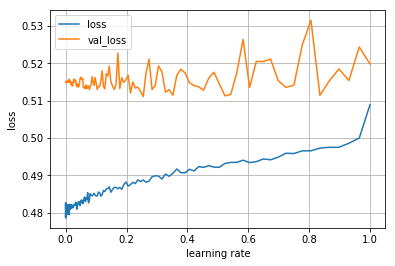

In [12]:
log = pd.read_csv("./LSTM/1_0_64_2000.log")
plt.plot(log['epoch'].values, log['loss'].values, label='loss')
plt.plot(log['epoch'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

plt.plot(log['lr'].values, log['loss'].values, label='loss')
plt.plot(log['lr'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.grid()
plt.show()

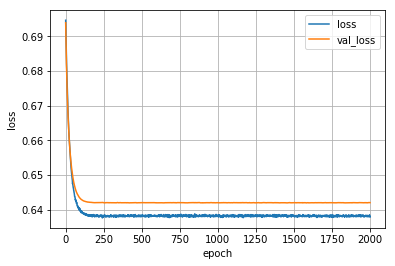

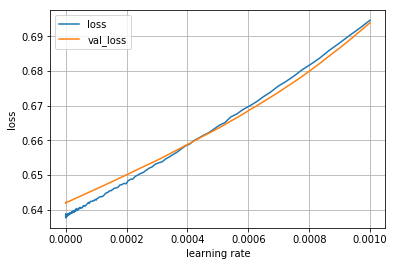

In [19]:
log = pd.read_csv("./LSTM/0.001_0_200_2000.log")
plt.plot(log['epoch'].values, log['loss'].values, label='loss')
plt.plot(log['epoch'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

plt.plot(log['lr'].values, log['loss'].values, label='loss')
plt.plot(log['lr'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.grid()
plt.show()

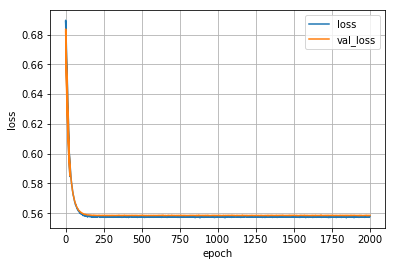

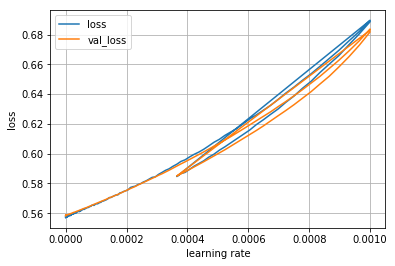

In [27]:
log = pd.read_csv("./LSTM/0.001_0_64_2000.log")
plt.plot(log['epoch'].values, log['loss'].values, label='loss')
plt.plot(log['epoch'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

plt.plot(log['lr'].values, log['loss'].values, label='loss')
plt.plot(log['lr'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.grid()
plt.show()

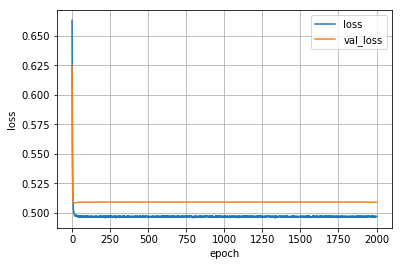

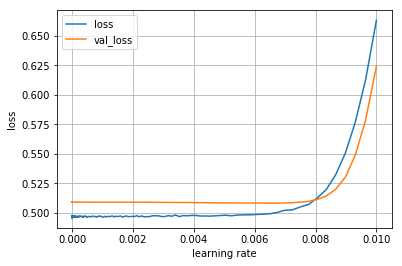

In [4]:
log = pd.read_csv("./LSTM/0.01_0_64_2000.log")
plt.plot(log['epoch'].values, log['loss'].values, label='loss')
plt.plot(log['epoch'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

plt.plot(log['lr'].values, log['loss'].values, label='loss')
plt.plot(log['lr'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.grid()
plt.show()

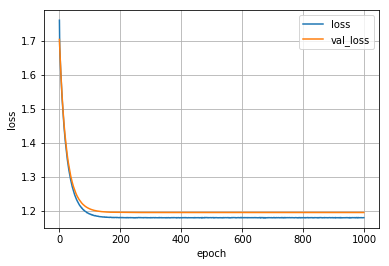

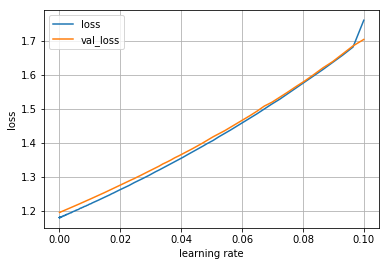

In [9]:
# ElasticNet
log = pd.read_csv("./LSTM/0.1_(1e-07, 0.001)_64_1000.log")
plt.plot(log['epoch'].values, log['loss'].values, label='loss')
plt.plot(log['epoch'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

plt.plot(log['lr'].values, log['loss'].values, label='loss')
plt.plot(log['lr'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.grid()
plt.show()